In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

from jupyterthemes import jtplot
jtplot.style('grade3')

# Read Data

In [2]:
df = pd.read_csv('./data_for_student_case.csv')
df.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271


# Imbalanced DataSet Exploration

In [3]:
type_name, type_count = np.unique(df['simple_journal'], return_counts=True)
for i in range(len(type_name)):
    print(str(type_name[i])+':', type_count[i], '('+str(100*np.round(type_count[i]/len(df),4))+'%)')

Chargeback: 345 (0.12%)
Refused: 53346 (18.37%)
Settled: 236691 (81.51%)


# Data Preprocessing

## Delete Refused Catagory

In [4]:
df_new = df[df['simple_journal'] != 'Refused']
type_name, type_count = np.unique(df_new['simple_journal'], return_counts=True)
for i in range(len(type_name)):
    print(str(type_name[i])+':', type_count[i], '('+str(100*np.round(type_count[i]/len(df_new),4))+'%)')

Chargeback: 345 (0.15%)
Settled: 236691 (99.85000000000001%)


## CVCResponseCode Aggregation

In [5]:
df_new['cvcRes'] = df_new['cvcresponsecode'].apply(lambda x: 3 if (x >= 3 and x<6) else x)

## Data Encoding

In [6]:
# 1.label
df_new['label'] = df['simple_journal'].apply(lambda x: 1 if x == 'Chargeback' else 0)

# 2.creationdate
df_new['creationdate'] = pd.to_datetime(df_new['creationdate'])
df_new['date'] = df_new['creationdate'].dt.date

# 3.txvariantcode
txc_enc = LabelEncoder()
txc_enc.fit(df_new['txvariantcode'])
df_new['txCode'] = txc_enc.transform(df_new['txvariantcode'])

# 4.issuercountrycode
issue_enc = LabelEncoder()
issue_enc.fit(df_new['issuercountrycode'].astype(str))
df_new['issuerCountry'] = issue_enc.transform(df_new['issuercountrycode'].astype(str))

# 5.accountcode
account_enc = LabelEncoder()
account_enc.fit(df_new['accountcode'])
df_new['account'] = account_enc.transform(df_new['accountcode'])

# 6.shopperinteraction
interaction_enc = LabelEncoder()
interaction_enc.fit(df_new['shopperinteraction'])
df_new['interaction'] = interaction_enc.transform(df_new['shopperinteraction'])

In [7]:
# 7.converting different currency to a homogeneous value
to_euro = {
    'AUD': 0.64147,
    'GBP': 1.1494,
    'MXN': 0.04169,
    'NZD': 0.59499,
    'SEK': 0.09859
}
def amount_to_euro(df_colums):
    amount, currency = df_colums
    return to_euro[currency] * amount / 100
df_new['euroAmount'] = df_new[['amount', 'currencycode']].apply(amount_to_euro, axis=1)

In [8]:
df_new.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,...,ip_id,card_id,cvcRes,label,date,txCode,issuerCountry,account,interaction,euroAmount
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,...,ip111778,card184798,0,1,2015-07-01,2,76,1,1,27.01512
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,...,ip78749,card151595,0,1,2015-07-02,2,76,1,1,18.71881
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,...,ip70594,card242142,0,1,2015-07-02,2,76,1,1,62.49331
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,...,ip113648,card181744,0,1,2015-07-03,2,76,1,1,45.81731
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,...,ip83553,card97271,0,1,2015-07-08,6,76,1,1,37.47931


# Data Visualization

In [9]:
df_fraud = df_new[df_new['label'] == 1]
df_benign = df_new[df_new['label'] == 0]

## Boxplot - Amount

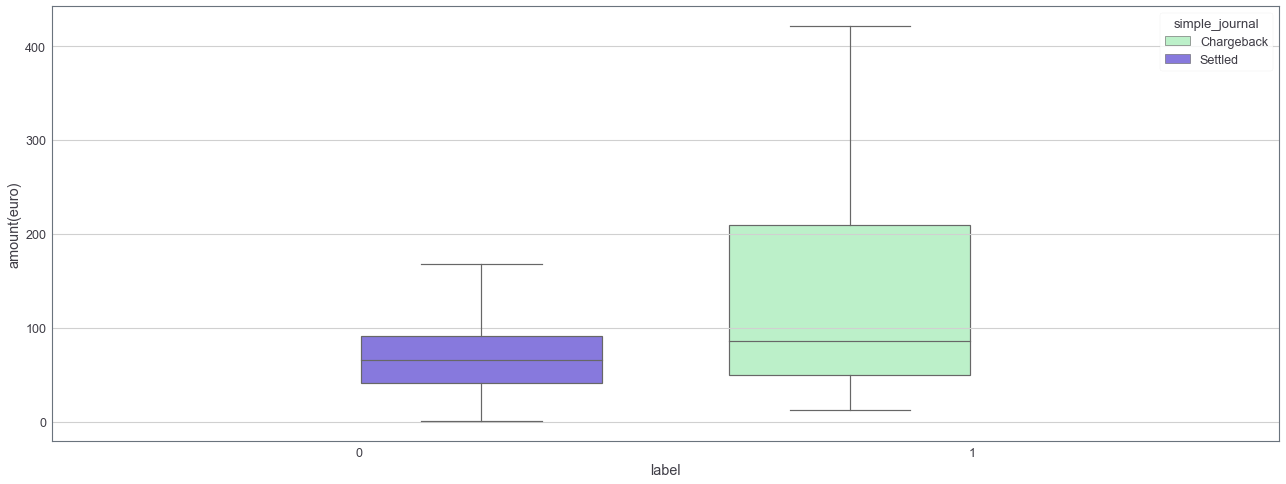

In [10]:
colors = ['#B3F9C5', '#7b68ee']
figure, (ax) = plt.subplots(1, figsize=(22,8))
ax = sns.boxplot(x='label', y='euroAmount', hue='simple_journal', data=df_new, 
                 showfliers=False, palette=colors
                 )
ax.set(xlabel='label', ylabel='amount(euro)')
plt.savefig('./figures/amountBoxplot.pdf', dpi=1200)
plt.show()

## Histogram - txCode/issuerCountry/account/cvcRes

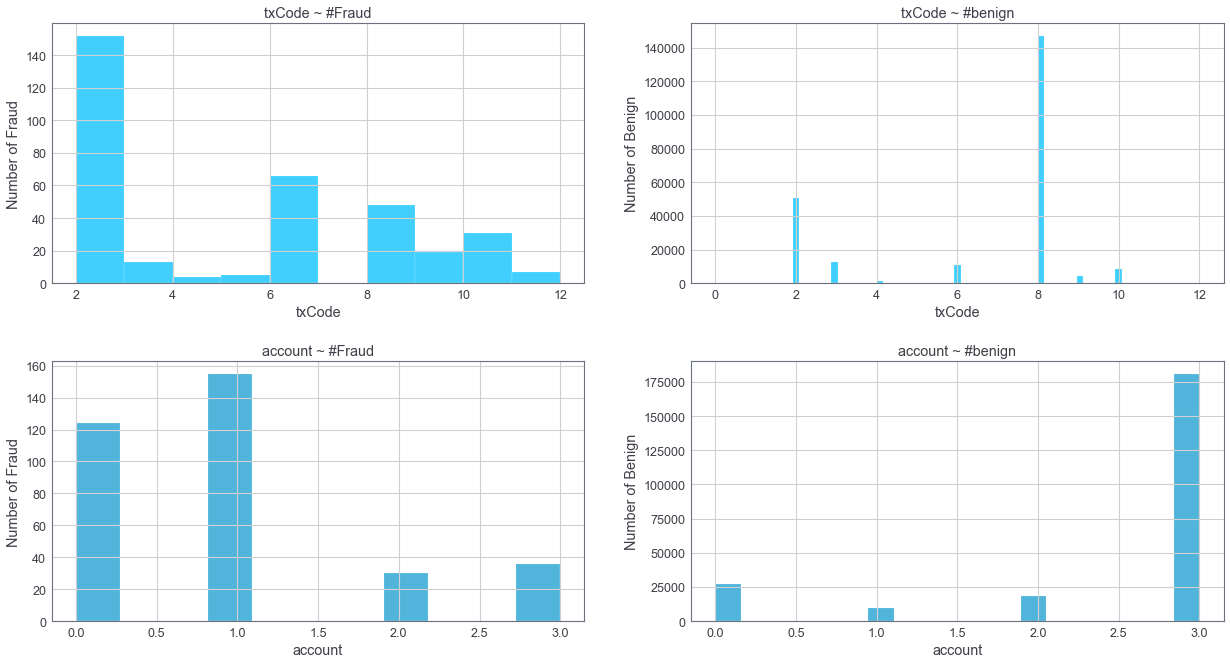

In [11]:
plt.figure(figsize=(21,11))
plt.subplots_adjust(wspace=0.2,hspace=0.3)

plt.subplot(221)
sns.histplot(x='txCode', data=df_fraud, color='#00bfff')
plt.ylabel('Number of Fraud')
plt.title('txCode ~ #Fraud')
plt.subplot(222)
sns.histplot(x='txCode', data=df_benign, color='#00bfff')
plt.ylabel('Number of Benign')
plt.title('txCode ~ #benign')

plt.subplot(223)
sns.histplot(x='account', data=df_fraud, color='#179ccf')
plt.ylabel('Number of Fraud')
plt.title('account ~ #Fraud')
plt.subplot(224)
sns.histplot(x='account', data=df_benign, color='#179ccf')
plt.ylabel('Number of Benign')
plt.title('account ~ #benign')

plt.savefig('./figures/txCode_account.pdf', dpi=1200)
plt.show()

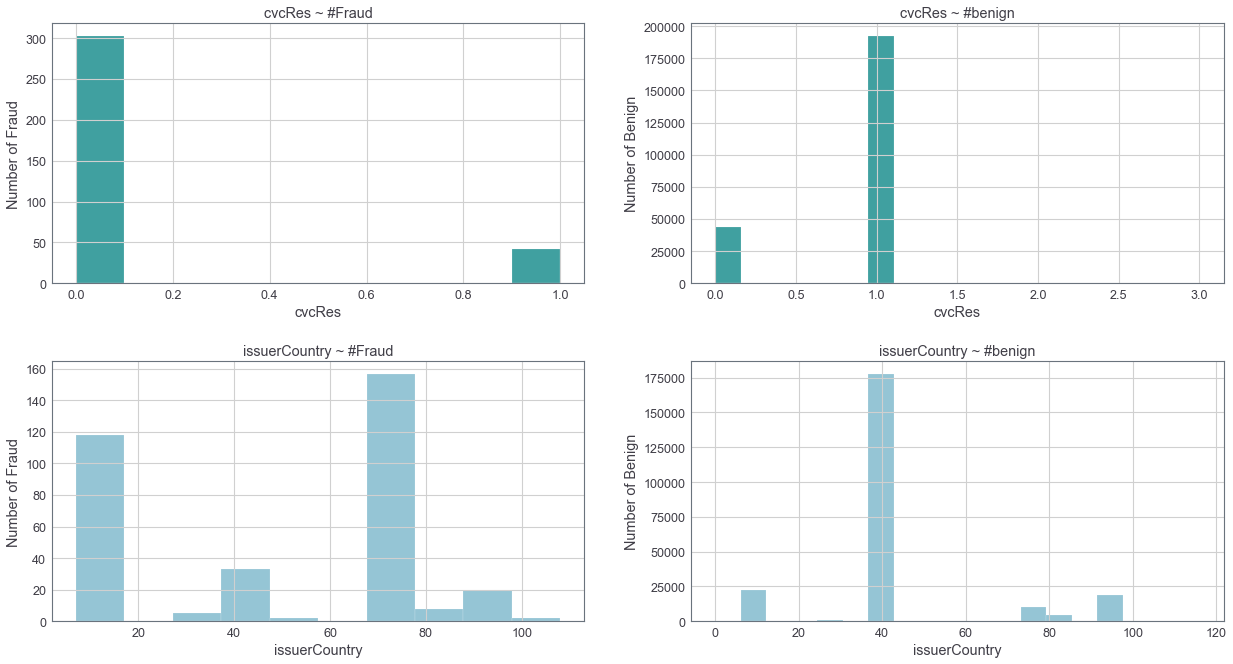

In [12]:
plt.figure(figsize=(21,11))
plt.subplots_adjust(wspace=0.2,hspace=0.3)

plt.subplot(221)
sns.histplot(x='cvcRes', data=df_fraud, color='#008080')
plt.ylabel('Number of Fraud')
plt.title('cvcRes ~ #Fraud')
plt.subplot(222)
sns.histplot(x='cvcRes', data=df_benign, color='#008080')
plt.ylabel('Number of Benign')
plt.title('cvcRes ~ #benign')

plt.subplot(223)
sns.histplot(x='issuerCountry', data=df_fraud, color='#72b2c7')
plt.ylabel('Number of Fraud')
plt.title('issuerCountry ~ #Fraud')
plt.subplot(224)
sns.histplot(x='issuerCountry', data=df_benign, color='#72b2c7')
plt.ylabel('Number of Benign')
plt.title('issuerCountry ~ #benign')

plt.savefig('./figures/cvcRes_issuerCountry.pdf', dpi=1200)
plt.show()